In [13]:
import numpy as np
import pylab as plt
from collections import Counter
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from pyabc.examples import tuberculosis
import pyabc.prior
from pyabc.utils import plot_marginals

## Intractable model by Tanaka et al. 2006 for spread of tuberculosis

![](img/transmission_process.png)

### model parameter
$\alpha$: rate with which each infectious host randomly infects other individuals from an unlimited supply of hosts

$\delta$: rate with which a host stops being infectious, either by recovering or dying

$\tau$: rate with which the pathogen of the host mutates randomly within the host, generating a novel haplotype under a single-locus infinite alleles model

$\theta = (\alpha, \delta, \tau)$

$y_{\theta} = (6,3,2,2,1,1,1,1,1,1,1)$: output, vector of clusters, that is different haplotypes. Each number represents the infectious hosts for this particular haplotype

### Observation
$\alpha = 0.2, \delta = 0, \tau = 0.198, m = 20$

assume, that $\delta, \tau$ are known and apply uniform prior

In [14]:
alpha = 0.2
delta = 0.1
tau = 0.198
m = 20
N = 2e7

prior_alpha = pyabc.Prior("uniform", 0.05, 1, name="alpha")
prior_delta = pyabc.Prior("uniform", 0, 0.05, name="delta")
prior_tau = pyabc.Prior("uniform", 0.01, 1, name="tau")

simulator = tuberculosis.simulator

In [15]:
min(prior_alpha.sample(10000))

0.050001869630827492

In [16]:
for i in range(100):
    params = [prior_alpha.sample(),prior_delta.sample(),prior_tau.sample()]
    y0 = simulator(*params)
    y0

In [17]:
list_of_sum = tuberculosis.summaries
for f in list_of_sum:
    print(f(y0))

16
5
1


In [18]:
rej = pyabc.RejectionSampler(priors=[prior_alpha, prior_delta, prior_tau], simulator=simulator, 
                             summaries=tuberculosis.summaries,
                             observation=y0, verbosity = 1)

In [19]:
rej.sample(nr_samples=1000, threshold=0.01)

Rejection sampler started with threshold: 0.01 and number of samples: 1000
Samples:   1000 - Threshold: 0.01 - Iterations:      66000 - Acceptance rate: 0.015152 - Time:    52.88 s


In [20]:
smc = pyabc.SMCSampler(priors=[prior_alpha, prior_delta, prior_tau], simulator=simulator, 
                             summaries=tuberculosis.summaries,
                             observation=y0, verbosity = 1)

In [21]:
smc.sample(nr_samples=1000, thresholds=[0.5,0.1,0.05,0.01])

SMC sampler started with thresholds: [0.5, 0.1, 0.05, 0.01] and number of samples: 1000
Rejection sampler started with threshold: 0.5 and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
starting iteration[ 3 ]
Iteration 3 completed
Samples:   1000 - Thresholds: 0.01 - Iterations:      76974 - Acceptance rate: 0.012991 - Time:   109.03 s


In [10]:
mcmc = pyabc.MCMCSampler(priors=[prior_alpha, prior_delta, prior_tau], simulator=simulator, 
                             summaries=tuberculosis.summaries,
                             observation=y0, verbosity = 1)

In [11]:
mcmc.sample(nr_samples=1000, threshold = 0.01, step_size = [0.001, 0.001, 0.005])

MCMC sampler started with threshold: 0.01 and number of samples: 1000
Rejection sampler started with threshold: 0.01 and number of samples: 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
24

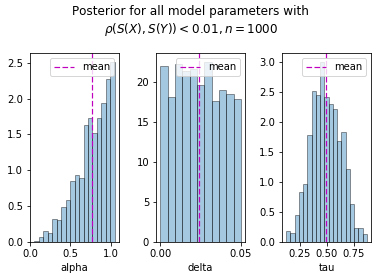

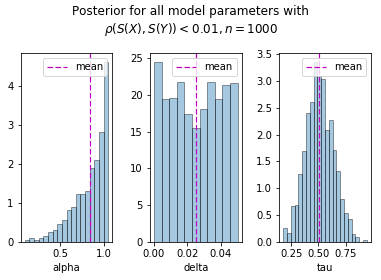

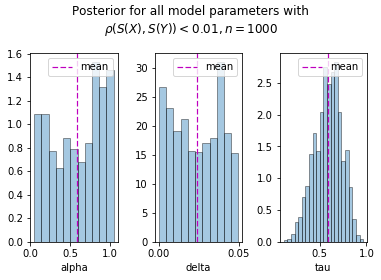

In [22]:
plot_marginals(rej)
plot_marginals(smc)
plot_marginals(mcmc)